In [2]:
pip install diffusers transformers accelerate peft datasets torch torchvision

In [3]:
# parameter-efficient fine-tuning

Loading Base Stable Diffusion Model

In [4]:
import torch
print(torch.cuda.is_available())

False


In [5]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [6]:
import torch
from diffusers import StableDiffusionPipeline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_id = 'runwayml/stable-diffusion-v1-5'

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype = torch.float16
).to(device)

print('Using device:', device)

/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use a

Using device: cpu


**Inject LoRA Layers**

Only UNet attention layers are adapted, base weights remain frozen


In [7]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r = 8,
    lora_alpha = 32,
    target_modules = ['to_q', 'to_k', 'to_v'],
    lora_dropout = 0.1,
    bias = 'none'
)

pipe.unet = get_peft_model(pipe.unet, lora_config)

**Freeze Base Model Weights**

Only LoRA parameters remain trainable

In [8]:
for param in pipe.text_encoder.parameters():
  param.requires_grad = False

for param in pipe.vae.parameters():
  param.requires_grad = False

In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

Designing Custom Dataset

In [10]:
class CustomImageDataset(Dataset):
  def __init__(self, image_dir, captions_file):
    self.image_dir = image_dir

    with open(captions_file, 'r') as f:
      self.data = [line.strip().split('|') for line in f.readlines()]

    self.transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_name, caption = self.data[idx]

    img_path = os.path.join(self.image_dir, img_name)
    image = Image.open(img_path).convert("RGB")
    image = self.transform(image)

    return image, caption

In [11]:
os.makedirs('custom_dataset/images', exist_ok = True)

In [12]:
from PIL import Image, ImageDraw
colors = ['red', 'green', 'blue', 'yellow', 'purple']

for i, color in enumerate(colors):
  img = Image.new('RGB', (512, 512), color = color)
  draw = ImageDraw.Draw(img)
  draw.text((180, 240), color, fill = 'white')

  img.save(f"custom_dataset/images/img{i+1}.jpg")

In [13]:
captions = [
    'img1.jpg| a red abstract image in Modern Art style',
    'img2.jpg| a green abstract image in Modern Art style',
    'img3.jpg| a blue abstract image in Modern Art style',
    'img4.jpg| a yellow abstract image in Modern Art style',
    'img5.jpg| a purple abstract image in Modern Art style'
]

with open('custom_dataset/captions.txt', 'w') as f:
  for line in captions:
    f.write(line + '\n')

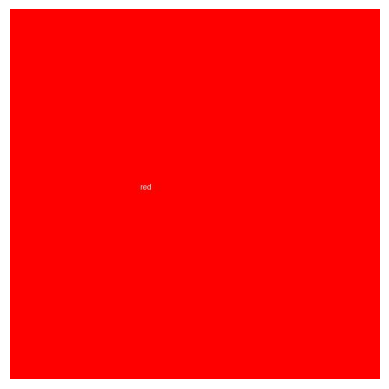

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('custom_dataset/images/img1.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [15]:
from torch.utils.data import DataLoader

dataset = CustomImageDataset(
    image_dir = 'custom_dataset/images',
    captions_file = 'custom_dataset/captions.txt'
)

dataloader = DataLoader(
    dataset,
    batch_size = 1,
    shuffle = True
)

Training Loop

In [ ]:
from torch.optim import AdamW

# Optimizer exists only to show LoRA is trainable (not used here)
optimizer = AdamW(
    pipe.unet.parameters(),
    lr=1e-4
)

pipe.unet.train()

print("Starting LoRA pipeline validation...\n")

for images, prompts in dataloader:
    images = images.to(device)
    prompts = list(prompts)

    with torch.no_grad():   # NO training, only validation
        _ = pipe(
            prompt=prompts,
            num_inference_steps=1,   # FAST
            guidance_scale=1.0
        )

    print("Pipeline executed successfully.")
    print("Image batch shape:", images.shape)
    print("Prompt used:", prompts[0])
    break   # IMPORTANT: run only once

print("\nLoRA pipeline validation complete.")


Starting LoRA pipeline validation...



  0%|          | 0/1 [00:00<?, ?it/s]

**Save LoRA Weights**

Only small LoRA files are saved (few MBs)

In [ ]:
pipe.unet.save_pretrained("lora_custom_style")

Inference with custom model

In [ ]:
pipe.load_lora_weights("lora_custom_style")

prompt = 'A landscape paintig in Modern Art style'

image = pipe(
    prompt,
    guidance_scale = 7.5,
    num_inference_steps = 50
).images[0]

image.save('Custom_output.png')